In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.facecolor'] = 'white'
from matplotlib import cm

from tqdm.auto import tqdm

import os
import ctypes

# Initialization

In [2]:
dirname = '../src/model_ctypes/_bondarenko/'
filename_so = os.path.join(dirname, 'model.so')

filename_so_abs = os.path.abspath(filename_so)

model = ctypes.CDLL(filename_so_abs)

model.initialize_states_default.argtypes = [
    np.ctypeslib.ndpointer(dtype=np.float64, ndim=1, flags='C_CONTIGUOUS')
]
model.initialize_states_default.restype = ctypes.c_void_p


model.compute_rates_algebraic.argtypes = [
    ctypes.c_double,
    np.ctypeslib.ndpointer(dtype=np.float64, ndim=1, flags='C_CONTIGUOUS'),
    np.ctypeslib.ndpointer(dtype=np.float64, ndim=1, flags='C_CONTIGUOUS'),
    np.ctypeslib.ndpointer(dtype=np.float64, ndim=1, flags='C_CONTIGUOUS'),
    np.ctypeslib.ndpointer(dtype=np.float64, ndim=1, flags='C_CONTIGUOUS')
]
model.compute_rates_algebraic.restype = ctypes.c_void_p

In [3]:
S_SIZE = 186
A_SIZE = 115
C_SIZE = 0

In [4]:
S = np.zeros(S_SIZE)
model.initialize_states_default(S)
R = np.zeros_like(S)

C = np.zeros(0)
A = np.zeros(A_SIZE)

In [5]:
model.compute_rates_algebraic(0, S, C, A, R)

4616189618054758400

# Main

In [6]:
from scipy.integrate import solve_ivp

In [7]:
def rhs(t, S, C, A, R):
    model.compute_rates_algebraic(t, S, C, A, R)
    return R

In [8]:
CL = 1000
n_beats = 1
t_sampling = 1

stim_period = CL # / 1000.
t_space = np.linspace(0, stim_period * n_beats, int(stim_period / t_sampling) * n_beats + 1, endpoint=True)
t_tail = np.linspace(stim_period * (n_beats - 1), stim_period * n_beats, int(stim_period / t_sampling) + 1, endpoint=True)
t_span = 0, t_space[-1]

sol = solve_ivp(rhs, y0=S,
                t_span=t_span, t_eval=t_space,
                args=(C, A, R),
                method='LSODA',
               )

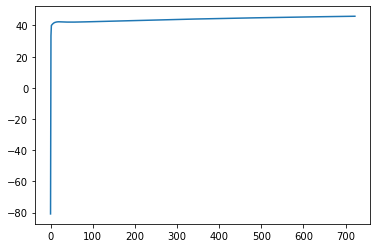

In [9]:
plt.plot(sol.y[1])